In [ ]:
# install wandb
!pip install wandb --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#do login in wandb
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [1]:
# import libraries
import os
import scipy.io
import random
from PIL import Image
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pickle
from torch.optim import lr_scheduler
import cv2

# ensure determinstic behavior
torch.backends.cudnn.deterministic = True

# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# remove warnings
import warnings
warnings.filterwarnings('ignore')

cpu


## Custom Dataset class created


In [2]:
class SegmentationDataset(Dataset):
  def __init__(self, transform1, input_dir, output_dir):
    self.input_dir = input_dir
    self.output_dir = output_dir
    self.images = os.listdir(input_dir)
    self.masks = os.listdir(output_dir)
    self.transform1 = transform1

  
  def __len__(self):
    return len(self.images)


  def __getitem__(self, index):
    image_path = os.path.join(self.input_dir, self.images[index])
    mask_path = os.path.join(self.output_dir, self.masks[index])

    image = np.array(Image.open(image_path).convert("RGB"), dtype=np.float32) / 255
    mask = np.array(Image.open(mask_path).convert("P"))

    if self.transform1:
      image = self.transform1(image)
      mask = cv2.resize(mask, (500, 333), interpolation=cv2.INTER_NEAREST)
    return image, mask



transform1 = transforms.Compose([transforms.ToTensor(), transforms.Resize((333, 500)), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
input_dir = "/content/drive/MyDrive/CV datasets/VOC Segmentation Dataset/images/"
output_dir = "/content/drive/MyDrive/CV datasets/VOC Segmentation Dataset/masks/"
segmentation_dataset = SegmentationDataset(transform1, input_dir, output_dir)


image, mask = next(iter(segmentation_dataset))
print(len(segmentation_dataset))
print(image.shape)
print(mask.shape)

1464
torch.Size([3, 333, 500])
(333, 500)


In [3]:
# randomply split the data
train_set, val_set, test_set = torch.utils.data.random_split(segmentation_dataset, [0.7, 0.2, 0.1])

print(len(train_set))
print(len(val_set))
print(len(test_set))


# dataloader created
train_dataloader = DataLoader(train_set, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=2, shuffle=False)


# label map
label_map = {'background': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6,
 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 
 'person': 15, 'potted plant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tv/monitor': 20}

1025
293
146


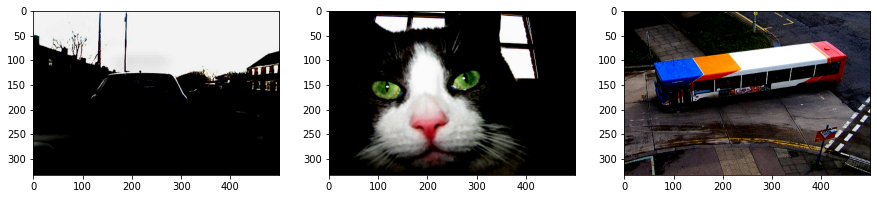

In [ ]:
# plot images
plt.figure(figsize=(15, 4))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.imshow(segmentation_dataset[i][0].permute(1, 2, 0))

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

train_labels = {key: 0 for key in range(21)} 
val_labels = {key: 0 for key in range(21)} 


for sample in train_set:
  unique_values = np.unique(sample[1])
  
  for val in unique_values:
    if val == 255:
      continue
    train_labels[val] += 1


for sample in test_set:
  unique_values = np.unique(sample[1])
  
  for val in unique_values:
    if val == 255:
      continue
    val_labels[val] += 1


print(train_labels)
print(val_labels)

{0: 1022, 1: 60, 2: 46, 3: 66, 4: 54, 5: 62, 6: 55, 7: 84, 8: 85, 9: 113, 10: 44, 11: 63, 12: 94, 13: 50, 14: 53, 15: 309, 16: 59, 17: 44, 18: 72, 19: 58, 20: 61}
{0: 146, 1: 12, 2: 7, 3: 10, 4: 7, 5: 8, 6: 7, 7: 19, 8: 15, 9: 18, 10: 8, 11: 8, 12: 10, 13: 8, 14: 6, 15: 48, 16: 7, 17: 5, 18: 6, 19: 8, 20: 7}


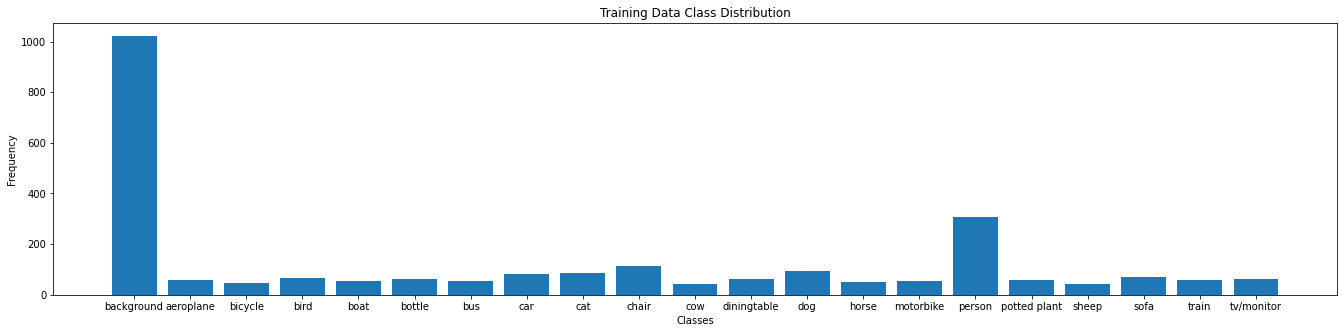

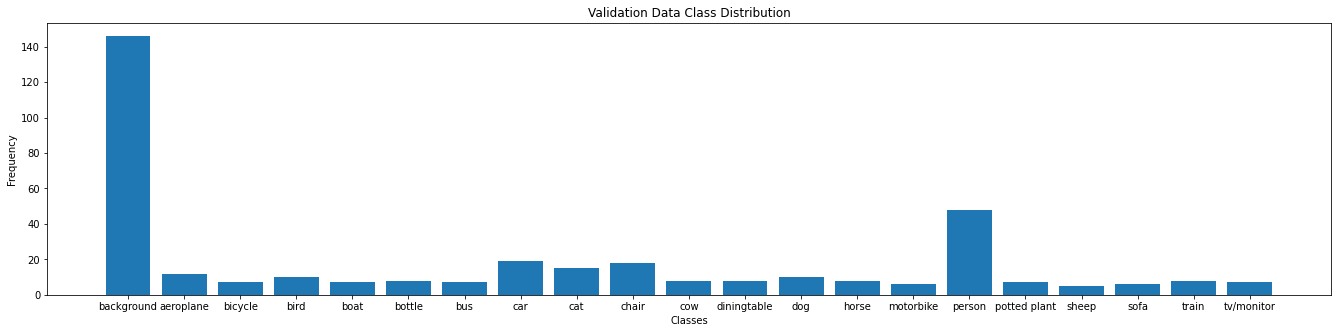

In [5]:
train_labels1 = list(label_map.keys())
train_values1 = list(train_labels.values())


val_labels1 = list(label_map.keys())
val_values1 = list(val_labels.values())


plt.figure(figsize=(23, 5))
plt.bar(train_labels1, train_values1, width=0.8)
plt.title("Training Data Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()
plt.close()


plt.figure(figsize=(23, 5))
plt.bar(val_labels1, val_values1, width=0.8)
plt.title("Validation Data Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()
plt.close()

## Training function

In [ ]:
def train_model(model, criterion, optimizer, scheduler, epochs, train_dataloader, val_dataloader):
  # command to log loss and gredients
  wandb.watch(model)
  total_train_loss = []
  total_val_loss = []


  # training loop
  for x in range(epochs):
    batch_train_loss = 0
    batch_val_loss = 0
    num_batches = 0
    
    for i, (images, labels)  in enumerate(train_dataloader):
      images = images.to(device)
      labels = labels.type(torch.LongTensor).to(device)
      
      # forward pass
      predicted = model(images)["out"]
      loss = criterion(predicted, labels)
      
      # backward pass
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      batch_train_loss += loss.item()
      num_batches += 1

    print("train loss :", loss.item())
    # scheduler.step()
    batch_train_loss /= num_batches
    total_train_loss.append(batch_train_loss)

    
    # validation accuracy
    with torch.no_grad():
      n_correct = 0
      n_samples = 0
      count = 0

      for i, (images, labels) in enumerate(val_dataloader):
        images = images.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        
        output = model(images)["out"]
        loss = criterion(output, labels)
        
        batch_val_loss += loss.item()
        count += 1

        _, predicted = torch.max(output, 1)
        n_samples += labels.size(0)
        print(predicted)
        n_correct += (predicted == labels).sum().item()
      
      acc = 100 * n_correct / n_samples
      batch_val_loss /= count
      total_val_loss.append(batch_val_loss) 
      wandb.log({"accuracy": acc, "Train loss": batch_train_loss, "Validation loss": batch_val_loss})
      print("val loss :", batch_val_loss)
      print("accuracy is :", acc / (500 * 333))
      print()
    
    
  print('Finished Training')

## Testing Function

In [ ]:
def test_model(model, test_dataloader):
  # testing loop
  with torch.no_grad():
    n_correct = 0
    n_samples = 0
    labels_list = []
    predicted_list = []
    misclassification = []

    for i, (images, labels) in enumerate(test_dataloader):
      images = images.to(device)
      labels = labels.labels.type(torch.LongTensor).to(device)
      
      output = model(images)
      _, predicted = torch.max(output, 1)
      n_samples += labels.size(0)
      n_correct += (predicted == labels).sum().item()
      

      # find misclassified images
      for label, prediction in zip(labels, predicted):
        if label != prediction:
          misclassification.append((images[prediction], label, prediction))
      
      labels_list.extend(labels.data.detach().cpu().numpy().tolist())
      predicted_list.extend(predicted.detach().cpu().numpy().tolist())

    # find accuracy and f1 score
    acc = 100 * (n_correct / n_samples)
    f1score = f1_score(labels.data.detach().cpu().flatten(), predicted.detach().cpu().flatten(), average="micro")*100
    print("accuracy is :", acc / (500 * 333))
    print("f1 score is :", f1score)
  
  # plot confusion matrix
  wandb.sklearn.plot_confusion_matrix(labels_list, predicted_list)
  
  # total misclassified images
  len(misclassification)
  return misclassification

## Train resnet50 model

In [ ]:
from torchvision.models.segmentation.fcn import FCN_ResNet50_Weights
from torchvision import models


# load pretrain model
resnet_model = models.segmentation.fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)
# num_features = resnet_model.fc.in_features


# add final layer
# resnet_model.fc1 = nn.Linear(num_features, 20)
resnet_model = resnet_model.to(device)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

In [ ]:
# set loss function, optimizer and scheduler
epochs = 5
batch_size = 2
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# # Intialize the wandb run
wandb.init(entity='jk12', project="A1", name='resnet_segmentation')


# # add config to run
wandb.config = {'learning_rate': learning_rate, "epochs": epochs, "batch_size": batch_size}


# train Resnet18 models
train_model(resnet_model, criterion, optimizer, scheduler, epochs, train_dataloader, val_dataloader)
print()
print()


# save resnet18 trained model
filename = '/content/drive/MyDrive/CV datasets/resnet50.sav'
pickle.dump(resnet_model, open(filename, 'wb'))
print("model saved")

In [ ]:
# load resnet18 model
filename = '/content/drive/MyDrive/CV datasets/resnet50.sav'
resnet_model = pickle.load(open(filename, 'rb'))
print("model loaded successfully")
print()


batch_size = 2
learning_rate = 0.05
epochs = 5


# Intialize the wandb run
wandb.init(entity='jk12', project="A1", name='resnet_segmentation')

# add config to run
wandb.config = {'learning_rate': learning_rate, "epochs": epochs, "batch_size": batch_size}


# test Resnet18 model
resnet_model = resnet_model.to(device)
misclassification_segementation = test_model(resnet_model, test_dataloader)

# close wandb
wandb.finish()